# Original Version

c:\Users\ngcao\BetterAGCAM\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[DEBUG] - MODEL:  vit_base_patch16_224
[DEBUG] - device:  cuda
[DEBUG] - image.shape:  torch.Size([1, 3, 224, 224])
[DEBUG] - class_num:  1000
[DEBUG] --- Computing AGCAM
[DEBUG] --- AGCAM running time:  1.048163890838623
[DEBUG] --- Computing BetterAGCAM
[DEBUG] - tensor_heatmaps.shape:  torch.Size([144, 1, 224, 224])
[DEBUG] - tensor_heatmaps:  tensor([[[[4.5505e-04, 4.5505e-04, 4.5505e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.5505e-04, 4.5505e-04, 4.5505e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.5505e-04, 4.5505e-04, 4.5505e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8522e-01,
           1.8522e-01, 1.8522e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8522e-01,
           1.8522e-01, 1.8522e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8522e-01,
           1.8522e-01, 1.8522e-01]]],


        [[[1.0203e-03, 1.0

(-0.5, 223.5, 223.5, -0.5)

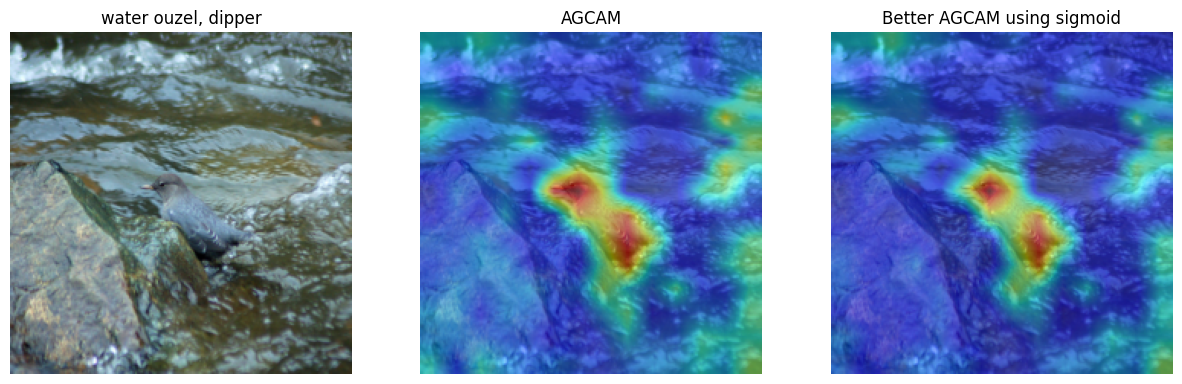

In [1]:
#generate heatmap for given image.
#If you want to generate heatmap for other image, change IMAGE_PATH

import torch
import torchvision.transforms as transforms
import numpy as np
import PIL
import matplotlib.pyplot as plt
from Datasets.ILSVRC_classes import classes
import torch.utils.model_zoo as model_zoo

#models
import Methods.AGCAM.ViT_for_AGCAM as ViT_Ours
import timm

#methods
from Methods.AGCAM.AGCAM import AGCAM
from Methods.AGCAM.Better_AGCAM import Better_AGCAM

import time
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

MODEL = 'vit_base_patch16_224'
IMG_SIZE=224
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Select Image which you want to generate a heatmap for.
path_list = [
    "samples/ILSVRC2012_val_00000125.jpeg",
    "samples/ILSVRC2012_val_00001372.jpeg",
    "samples/ILSVRC2012_val_00001854.jpeg",
    "samples/catdog.png",
    "samples/dogbird.png",
    "C:/Users/ngcao/Documents/TFE_XAI_ViT/imagenet/val/n01601694/ILSVRC2012_val_00029430.JPEG"
]
IMAGE_PATH = path_list[-1]

# Load the model parameter provided by the Timm library
state_dict = model_zoo.load_url('http://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth', progress=False, map_location=device)

# Image transformation for ImageNet ILSVRC 2012.
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# For convert the input image into original distribution to display
unnormalize = transforms.Compose([
    transforms.Normalize([0., 0., 0.], [1/0.5, 1/0.5, 1/0.5]),
    transforms.Normalize([-0.5, -0.5, -0.5], [1., 1., 1.,])
])


# Open the input image and transform
image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to(device)

class_num=1000

print("[DEBUG] - MODEL: ", MODEL)
print("[DEBUG] - device: ", device)
print("[DEBUG] - image.shape: ", image.shape)
print("[DEBUG] - class_num: ", class_num)


# Models and Methods
test_model = timm.create_model(MODEL, pretrained=True, num_classes=class_num).to(device)
model = ViT_Ours.create_model(MODEL, pretrained=True, num_classes=class_num).to(device)
model.load_state_dict(state_dict, strict=True)
model.eval()

agc_method = AGCAM(model)
betterAGC_method = Better_AGCAM(model)

# Generate heatmap using AGCAM method
with torch.enable_grad():
    print("[DEBUG] --- Computing AGCAM")
    start_time = time.time()
    
    prediction, agc_heatmap = agc_method.generate(image)
    agc_heatmap = transforms.Resize((224, 224))(agc_heatmap[0])
    agc_heatmap = (agc_heatmap - agc_heatmap.min())/(agc_heatmap.max()-agc_heatmap.min())
    agc_heatmap = agc_heatmap.detach().cpu().numpy()
    agc_heatmap = np.transpose(agc_heatmap, (1, 2, 0))
    
    print("[DEBUG] --- AGCAM running time: ", time.time() - start_time)
    
# Generate heatmap using BetterAGCAM method
with torch.enable_grad():
    print("[DEBUG] --- Computing BetterAGCAM")
    start_time = time.time()   
    prediction, heatmaps, output = betterAGC_method.generate(image)
    
with torch.no_grad():
    tensor_heatmaps = heatmaps[0].reshape(144, 1, 14, 14)
    tensor_heatmaps = transforms.Resize((224, 224))(tensor_heatmaps)
    print("[DEBUG] - tensor_heatmaps.shape: ", tensor_heatmaps.shape)    
    print("[DEBUG] - tensor_heatmaps: ", tensor_heatmaps)    
    
    min_vals = tensor_heatmaps.amin(dim=(2, 3), keepdim=True)  # Min across width and height
    max_vals = tensor_heatmaps.amax(dim=(2, 3), keepdim=True)  # Max across width and height

    print("[DEBUG] - min_vals: ", min_vals)    
    print("[DEBUG] - max_vals: ", max_vals)    

    tensor_heatmaps = (tensor_heatmaps - min_vals + 1e-7) / (max_vals - min_vals + 1e-7)

    print("[DEBUG] - tensor_heatmaps.shape after normalization: ", tensor_heatmaps.shape)    
    print("[DEBUG] - tensor_heatmaps: ", tensor_heatmaps)    

    new_image = torch.mul(tensor_heatmaps, image)
    print("[DEBUG] - new_image.shape: ", new_image.shape)    
    print("[DEBUG] - new_image: ", new_image)    
    
    output_mask = test_model(new_image)
    print("[DEBUG] - output_mask: ", output_mask)
    
    agc_scores = output_mask[:, prediction.item()] - output[0, prediction.item()]
    agc_scores = torch.sigmoid(agc_scores)
    # agc_scores = torch.softmax(agc_scores, axis = 0)
    agc_scores = agc_scores.reshape(heatmaps[0].shape[0], heatmaps[0].shape[1])

    print("[DEBUG] - agc_scores.shape: ", agc_scores.shape)    
    print("[DEBUG] - agc_scores: ", agc_scores)  

    my_cam = (agc_scores[:, :, None, None, None] * heatmaps[0].to(device)).sum(axis=(0, 1))
    my_cam = transforms.Resize((224, 224))(my_cam)
    my_cam = (my_cam - my_cam.min())/(my_cam.max()-my_cam.min())
    my_cam = my_cam.detach().cpu().numpy()
    my_cam = np.transpose(my_cam, (1, 2, 0))
    
    print("[DEBUG] - my_cam.shape: ", my_cam.shape)    
    print("[DEBUG] - my_cam: ", my_cam)  
    
    print("[DEBUG] --- BetterAGCAM running time: ", time.time() - start_time)
   

# Display final heatmap
image = unnormalize(image)
image = image.detach().cpu().numpy()[0]
image = np.transpose(image, (1, 2, 0))
fig, axs = plt.subplots(1,3, figsize=(15, 70))
axs[0].set_title(classes[prediction.item()])
axs[0].imshow(image)
axs[0].axis('off')

axs[1].set_title('AGCAM')
axs[1].imshow(image)
axs[1].imshow(agc_heatmap, cmap='jet', alpha=0.5)
axs[1].axis('off')

axs[2].set_title('Better AGCAM using sigmoid')
axs[2].imshow(image)
axs[2].imshow(my_cam, cmap='jet', alpha=0.5)
axs[2].axis('off')